# Demo of CV task for seafloor wreckage

#### In this demo, we have provided a baseline model for a basic computer vision task. Here we generate a classification model to distinguish if an underwater SAR/sonar image is a downed plane, sunken ship, or empty (i.e. no object detected on the seafloor). More advanced applications of this model would include labeled bounding boxes/object detection, retraining given a new set of images, adversarial robustness, and more complex file types (.h5 extensions specifically).
#### This notebook walks through data augmentation, model creation, model training, and prediction using a transfer learning approach with RESNET-50.

#### No Warranty

NO WARRANTY. THIS DEFENSE INNOVATION UNIT MATERIAL MAKES NO WARRANTIES OF ANY KIND, EITHER EXPRESSED OR IMPLIED, AS TO ANY MATTER INCLUDING,
BUT NOT LIMITED TO, WARRANTY OF FITNESS FOR PURPOSE OR MERCHANTABILITY, EXCLUSIVITY, OR RESULTS OBTAINED FROM USE
OF THE MATERIAL. THE DEFENSE INNOVATION UNIT DOES NOT MAKE ANY WARRANTY OF ANY KIND WITH RESPECT TO FREEDOM FROM
PATENT, TRADEMARK, OR COPYRIGHT INFRINGEMENT.


## Step 0: Setting up the notebook and the data pipeline



**NOTE** This cell should be edited to specify the current working directory.

In [1]:
### Insert file path HERE ###
import os
import sys

# - Top-level Directories
DIU_AMMO_HOME = os.path.abspath(os.environ.get("DIU_AMMO_HOME", "../../"))
print(f"DIU_AMMO_HOME: {DIU_AMMO_HOME}")
DIU_AMMO_DATA_DIR = os.environ.get(
    "DIU_AMMO_DATA_DIR", os.path.join(DIU_AMMO_HOME, "../../data")
)
if not os.path.isdir(DIU_AMMO_DATA_DIR):
    print("DATA_AMMO_DATA_DIR DNE. Aborting.")
    sys.exit(1)
print(f"DIU_AMMO_DATA_DIR: {DIU_AMMO_DATA_DIR}")
DIU_AMMO_MODELS_DIR = os.environ.get(
    "DIU_AMMO_MODELS_DIR", os.path.join(DIU_AMMO_HOME, "../../resources/models")
)
if not os.path.isdir(DIU_AMMO_MODELS_DIR):
    print("DIU_AMMO_MODELS_DIR DNE. Aborting.")
    sys.exit(1)
print(f"DIU_AMMO_MODELS_DIR: {DIU_AMMO_MODELS_DIR}")

DIU_AMMO_HOME: /home/jovyan/work
DIU_AMMO_DATA_DIR: /home/jovyan/work/data
DIU_AMMO_MODELS_DIR: /home/jovyan/work/models


In [2]:
# - Data: Balanced Dir
DIU_AMMO_DATA_BALANCED_DIR = os.environ.get(
    "DIU_AMMO_DATA_BALANCED_DIR",
    os.path.join(DIU_AMMO_DATA_DIR, "balanced_training_validation_set"),
)
if not os.path.isdir(DIU_AMMO_DATA_BALANCED_DIR):
    print("DIU_AMMO_DATA_BALANCED_DIR DNE. Aborting.")
    sys.exit(1)

# - Data: Unbalanced Dir
DIU_AMMO_DATA_UNBALANCED_DIR = os.environ.get(
    "DIU_AMMO_DATA_UNBALANCED_DIR",
    os.path.join(DIU_AMMO_DATA_DIR, "unbalanced_training_validation_set"),
)
if not os.path.isdir(DIU_AMMO_DATA_UNBALANCED_DIR):
    print("DIU_AMMO_DATA_UNBALANCED_DIR DNE. Aborting.")
    sys.exit(1)

# - Data: Test Dir
DIU_AMMO_DATA_TEST_DIR = os.environ.get(
    "DIU_AMMO_DATA_TEST_DIR",
    os.path.join(DIU_AMMO_DATA_DIR, "test_set"),
)
if not os.path.isdir(DIU_AMMO_DATA_TEST_DIR):
    print("DIU_AMMO_DATA_TEST_DIR DNE. Aborting.")
    sys.exit(1)

# - Models: Model Dir
DIU_AMMO_MODELS_DIR = os.environ.get(
    "DIU_AMMO_MODELS_DIR",
    os.path.join(DIU_AMMO_HOME, "models"),
)
if not os.path.isdir(DIU_AMMO_MODELS_DIR):
    print("DIU_AMMO_MODELS_DIR DNE. Aborting.")
    sys.exit(1)

print(f"Success. All data present at top-level directory: [{DIU_AMMO_HOME}].")

Success. All data present at top-level directory: [/home/jovyan/work].


#### Import libraries 

In [3]:
import copy
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.io as io

import seaborn as sns

from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import random_split
from torchsummary import summary
from torchvision.transforms.transforms import CenterCrop

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

print(f"All dependencies imported at runtime.")

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    USE_GPU = False  # override from desired state

print(
    f"Utilizing [{'GPU' if USE_GPU else 'CPU'}] with {device}:[{torch.cuda.get_device_name(0) if USE_GPU else ''}]."
)

All dependencies imported at runtime.
Utilizing [GPU] with cuda:[Quadro M2000M].


#### Understanding the data and other notes

The data is currently segmented into 3 classes:

0. Plane (38/38)
1. Empty seafloor (378/50)
2. Ship (239/50)

Totals: 655/138

The numbers above indicate how many of each are in the full dataset versus how many are in a more balanced, randomly-selected dataset. Of note, the number of plane images in the dataset is miniscule in comparison to the other 2 classes. This imbalance led to strong model bias toward ship images. The resulting validation and test accuracies for plane images suffered significantly as the model was more likely to assign images on the boundary as ships. This was significantly alleviated with more balanced sets.

The other issue to consider is data pipeline standardization. As seen below, images are of various size and definition.

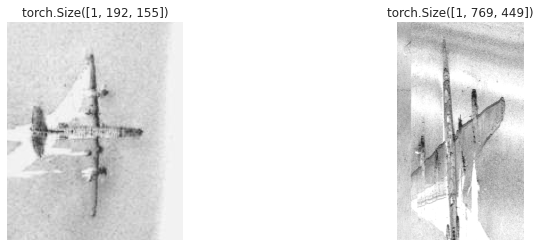

In [4]:
figures = [
    os.path.join(DIU_AMMO_DATA_UNBALANCED_DIR, "plane", "plane-39.png"),
    os.path.join(DIU_AMMO_DATA_UNBALANCED_DIR, "plane", "plane-14.png"),
]
fig, axarr = plt.subplots(nrows=1, ncols=len(figures), figsize=(12, 4))
for idx, unbalanced_image_path in enumerate(figures):
    unbalanced_torch_image = io.read_image(unbalanced_image_path)
    unbalanced_test_image = Image.open(unbalanced_image_path).convert("L")
    axarr[idx].axis("off")
    axarr[idx].set_title(f"{unbalanced_torch_image.size()}")
    axarr[idx].imshow(
        np.asarray(unbalanced_test_image), cmap="gray_r", vmin=0, vmax=255
    )
fig.show()

#### Gather user input and variables

This cell contains most of the editable and selectable features of the model. User should edit the paths for data location and choose:
1. The standardized size of the images (e.g. 150x150 pixels)
2. Mini batch size used during training
3. Learning rate used by the optimizer
4. The number of epochs used to train the model
5. Whether or not to use the full dataset or the balanced version for
training the model.




In [5]:
# Location of images
full_data_directory = DIU_AMMO_DATA_UNBALANCED_DIR
balanced_data_directory = DIU_AMMO_DATA_BALANCED_DIR
test_data_directory = DIU_AMMO_DATA_TEST_DIR

# Image size
pxls = 150

# Batch size (recommend 20 for balanced set, 100 for full set)
bs = 100

# Learning rate
rate = 0.0005

# Number of epochs
num_epochs = 20

# Select the full image dataset (0) or the balanced dataset (1)
balanced = 0

### END User inputs ###

#### Prepare the image transformations

In [6]:
# Additional transforms to consider for the training set:
# RandomRotation, RandomHorizontalFlip, CenterCrop

image_transforms = transforms.Compose(
    [
        transforms.Resize(size=(pxls, pxls)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

#### Prepare the DataLoaders

In [7]:
# Number of classes
num_classes = 3

if balanced == False:
    images = datasets.ImageFolder(root=full_data_directory, transform=image_transforms)
    # Random split of training, validation sets (80/20)
    num_items = len(images)
    num_train = round(num_items * 0.8)
    num_val = num_items - num_train
    train_ds, val_ds = random_split(images, [num_train, num_val])
else:
    images = datasets.ImageFolder(
        root=balanced_data_directory, transform=image_transforms
    )
    # Random split of training, validation sets (80/20)
    num_items = len(images)
    num_train = round(num_items * 0.8)
    num_val = num_items - num_train
    train_ds, val_ds = random_split(images, [num_train, num_val])

test_ds = datasets.ImageFolder(root=test_data_directory, transform=image_transforms)

# Create training, validation, and test data loaders
train_data = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_data = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=False)
test_data = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=False)

# Size of data, to be used for calculating average Loss and accuracy
train_data_size = len(train_ds)
valid_data_size = len(val_ds)
test_data_size = len(test_ds)

# Print the training, validation, and test set data sizes
train_data_size, valid_data_size, test_data_size

(524, 131, 361)

## Step 1: Create proposed model architectures

#### Download and modify pretrained models

We use a ResNet50 model architecture pretrained on the ImageNet dataset and modify the final fully connected layers to produce our 3 class scores.

In [8]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final layer
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(nn.Linear(fc_inputs, 256), nn.ReLU(), nn.Linear(256, 3))

model_CE = copy.deepcopy(resnet50)

Lastly, ensure that our models are on the GPU and read through the summary to ensure that we have the correct architecture

In [9]:
model_CE = model_CE.to(device=device)

In [10]:
# comment out if desired
summary(model_CE, (3, pxls, pxls))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 75, 75]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 75, 75]          (128)
├─ReLU: 1-3                              [-1, 64, 75, 75]          --
├─MaxPool2d: 1-4                         [-1, 64, 38, 38]          --
├─Sequential: 1-5                        [-1, 256, 38, 38]         --
|    └─Bottleneck: 2-1                   [-1, 256, 38, 38]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 38, 38]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 38, 38]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 38, 38]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 38, 38]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 38, 38]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 38, 38]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 38, 38]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 75, 75]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 75, 75]          (128)
├─ReLU: 1-3                              [-1, 64, 75, 75]          --
├─MaxPool2d: 1-4                         [-1, 64, 38, 38]          --
├─Sequential: 1-5                        [-1, 256, 38, 38]         --
|    └─Bottleneck: 2-1                   [-1, 256, 38, 38]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 38, 38]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 38, 38]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 38, 38]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 38, 38]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 38, 38]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 38, 38]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 38, 38]  

## Step 2: Create training and validation loops

### Create the optimizers

In [11]:
optimizer_CE = optim.Adam(model_CE.parameters(), lr=rate)

### Define loss functions

In [12]:
# Use Cross Entropy loss as a starting point
def cross_entropy_loss(outputs, labels):
    loss_func = nn.CrossEntropyLoss()
    return loss_func(outputs, labels)

### Define prediction functions

In [13]:
def cross_entropy_preds(outputs):
    ret, predictions = torch.max(outputs.data, 1)
    return predictions

### Create validation loop

In [14]:
def check_val_accuracy(model, data_loader, loss_func, predict_func):
    # No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        # Validation loop
        valid_loss = 0
        valid_acc = 0
        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            # Compute loss
            loss = loss_func(outputs, labels)
            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)
            # Calculate validation accuracy
            predictions = predict_func(outputs.data)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)
        valid_acc = valid_acc / valid_data_size
        valid_loss = valid_loss / valid_data_size
        print(
            "Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(valid_loss, valid_acc)
        )
        return (valid_acc, valid_loss)

### Create training loop

In [15]:
best_model = model_CE


def train_model(model, optimizer, loss_func, predict_func, epochs=4):
    train_accs = np.zeros(epochs)
    valid_accs = np.zeros(epochs)
    train_losses = np.zeros(epochs)
    valid_losses = np.zeros(epochs)

    best_val_acc = 0.0

    model = model.to(device=device)
    epoch_num = 0
    for epoch in range(epochs):
        epoch_num += 1
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = loss_func(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute the accuracy
            predictions = predict_func(outputs.data)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            print(
                "Iteration: {:03d}, Loss: {:.4f}, Accuracy: {:.4f}".format(
                    i, loss.item(), acc.item()
                )
            )

        train_acc = train_acc / train_data_size
        train_loss = train_loss / train_data_size
        print("Training: Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss, train_acc))
        train_accs[epoch_num - 1], train_losses[epoch_num - 1] = train_acc, train_loss
        valid_accs[epoch_num - 1], valid_losses[epoch_num - 1] = check_val_accuracy(
            model, valid_data, loss_func, predict_func
        )
        if valid_accs[epoch_num - 1] > best_val_acc:
            best_model = model

        # Print elapsed time for epoch
        epoch_end = time.time()
        print("Epoch Time: {:.2f} secs".format(epoch_end - epoch_start))

    return (train_accs, train_losses, valid_accs, valid_losses)

## Step 3: Train the model

### Run training loops

In [16]:
# Cross entropy loss with ResNet50
accs_losses_CE = train_model(
    model_CE, optimizer_CE, cross_entropy_loss, cross_entropy_preds, num_epochs
)
train_accs_CE, train_losses_CE, valid_accs_CE, valid_losses_CE = accs_losses_CE

Epoch: 1/20
Iteration: 000, Loss: 1.2079, Accuracy: 0.1900
Iteration: 001, Loss: 0.7189, Accuracy: 0.9300
Iteration: 002, Loss: 0.7875, Accuracy: 0.9200
Iteration: 003, Loss: 0.7016, Accuracy: 0.8900
Iteration: 004, Loss: 0.6429, Accuracy: 0.9200
Iteration: 005, Loss: 0.7542, Accuracy: 0.9167
Training: Loss: 0.8091, Accuracy: 0.7767
Validation: Loss: 0.8614, Accuracy: 0.6183
Epoch Time: 9.72 secs
Epoch: 2/20
Iteration: 000, Loss: 0.6333, Accuracy: 0.7400
Iteration: 001, Loss: 0.5356, Accuracy: 0.8600
Iteration: 002, Loss: 0.2666, Accuracy: 0.9700
Iteration: 003, Loss: 0.3081, Accuracy: 0.9500
Iteration: 004, Loss: 0.3989, Accuracy: 0.9100
Iteration: 005, Loss: 0.4524, Accuracy: 0.9167
Training: Loss: 0.4296, Accuracy: 0.8874
Validation: Loss: 0.4178, Accuracy: 0.9084
Epoch Time: 9.61 secs
Epoch: 3/20
Iteration: 000, Loss: 0.3121, Accuracy: 0.9400
Iteration: 001, Loss: 0.3128, Accuracy: 0.9300
Iteration: 002, Loss: 0.2431, Accuracy: 0.9500
Iteration: 003, Loss: 0.2540, Accuracy: 0.9400


### Visualize training results

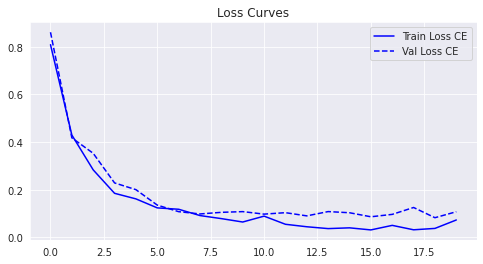

In [17]:
# Loss curves
plt.rcParams["figure.figsize"] = (8, 4)
plt.plot(
    np.arange(0, len(train_losses_CE)),
    train_losses_CE,
    label="Train Loss CE",
    color="blue",
)
plt.plot(
    np.arange(0, len(valid_losses_CE)),
    valid_losses_CE,
    label="Val Loss CE",
    color="blue",
    linestyle="dashed",
)
plt.legend()
plt.title("Loss Curves")
plt.show()

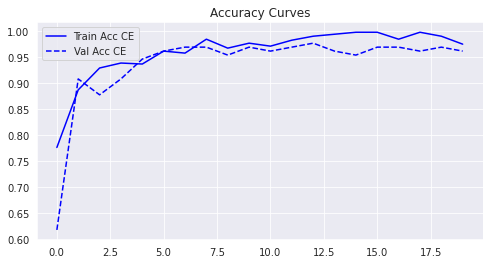

In [18]:
# Accuracy curves
plt.plot(
    np.arange(0, len(train_accs_CE)), train_accs_CE, label="Train Acc CE", color="blue"
)
plt.plot(
    np.arange(0, len(valid_accs_CE)),
    valid_accs_CE,
    label="Val Acc CE",
    color="blue",
    linestyle="dashed",
)
plt.legend()
plt.title("Accuracy Curves")
plt.show()

## Step 4: Evaluate the models

### Create individual image predictions

In [19]:
# Predict function outputs raw, unnormalized class scores
def predict(model, test_image_name):
    transform = image_transforms
    test_image = Image.open(test_image_name).convert("RGB")
    plt.rcParams["figure.figsize"] = (4.5, 4.5)
    plt.axis("off")
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, pxls, pxls).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, pxls, pxls)
    with torch.no_grad():
        model.eval()
        # Model outputs probabilities
        ps = model(test_image_tensor)
        topk, topclass = ps.topk(1, dim=1)
        print("Predicted Debris Class", ps)

Predicted Debris Class tensor([[ 4.3715, -3.1032,  1.3194]], device='cuda:0')


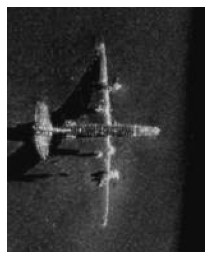

In [20]:
validation_image = os.path.join(DIU_AMMO_DATA_UNBALANCED_DIR, "plane", "plane-39.png")
predict(model_CE, validation_image)

### Visualize saliency maps

In [21]:
def compute_saliency_map(model, test_image_name, correct_class):
    transform = image_transforms
    test_image = Image.open(test_image_name).convert("RGB")
    test_image_tensor = transform(test_image)
    # Image underlying saliency map has been cropped and resized
    t1 = transforms.CenterCrop(size=256)
    t2 = transforms.Resize(size=224)
    test_image_cropped = t2(t1(test_image))

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, pxls, pxls).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, pxls, pxls)

    test_image_tensor.requires_grad_()
    # Retrieve score for correct class
    class_scores = model(test_image_tensor)
    correct_class_score = class_scores[0, correct_class - 1]

    # Do backpropagation to get the derivative of the output based on the image
    correct_class_score.backward()

    saliency, _ = torch.max(test_image_tensor.grad.data.abs(), dim=1)
    saliency = saliency.reshape(pxls, pxls)

    # Plot the image side-by-side with saliency map overlay
    plt.rcParams["figure.figsize"] = (8, 5.5)
    extent = 0, 224, 0, 224
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(test_image)
    ax[0].axis("off")
    ax[1].imshow(test_image_cropped, extent=extent)
    ax[1].imshow(saliency.cpu(), cmap="hot", alpha=0.5, extent=extent)
    ax[1].axis("off")
    plt.show()

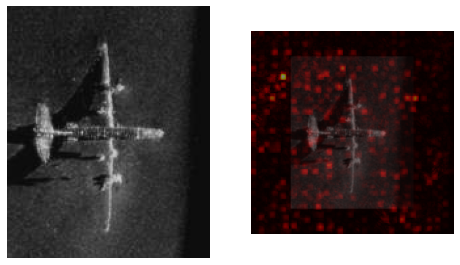

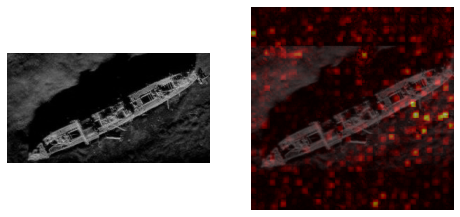

In [22]:
# Edit paths for user environment
saliency_images = [
    os.path.join(DIU_AMMO_DATA_UNBALANCED_DIR, "plane", "plane-39.png"),
    os.path.join(DIU_AMMO_DATA_UNBALANCED_DIR, "ship", "ship-008.png"),
]
for saliency_image in saliency_images:
    compute_saliency_map(best_model, saliency_image, 2)

### Visualize confusion matrices

In [23]:
def predict_batch(model, data_loader, predict_func):
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            predictions = predict_func(outputs.data)
            if j == 0:
                preds_full = predictions
                labels_full = labels
            else:
                preds_full = torch.concat((preds_full, predictions))
                labels_full = torch.concat((labels_full, labels))

    preds_full = preds_full.to(device)
    labels_full = labels_full.to(device)
    preds_full = preds_full.cpu().detach().numpy()
    labels_full = labels_full.cpu().detach().numpy()
    return (preds_full, labels_full)

In [24]:
def print_metrics(cf_mat):
    plane_acc = cf_mat[0, 0] / cf_mat.sum(axis=1)[0]
    seafloor_acc = cf_mat[1, 1] / cf_mat.sum(axis=1)[1]
    ship_acc = cf_mat[2, 2] / cf_mat.sum(axis=1)[2]
    overall_acc = (cf_mat[0, 0] + cf_mat[1, 1] + cf_mat[2, 2]) / cf_mat.sum()
    print("Plane accuracy: {:.1%}".format(plane_acc))
    print("Empty seafloor accuracy: {:.1%}".format(seafloor_acc))
    print("Ship accuracy: {:.1%}".format(ship_acc))
    print("Overall accuracy: {:.1%}".format(overall_acc))
    return

In [25]:
valid_preds, valid_labels = predict_batch(best_model, valid_data, cross_entropy_preds)
val_mat = confusion_matrix(valid_labels, valid_preds)
val_mat

array([[ 7,  0,  1],
       [ 0, 70,  0],
       [ 4,  0, 49]])

In [26]:
print_metrics(val_mat)

Plane accuracy: 87.5%
Empty seafloor accuracy: 100.0%
Ship accuracy: 92.5%
Overall accuracy: 96.2%


In [27]:
test_preds, test_labels = predict_batch(best_model, test_data, cross_entropy_preds)
test_mat = confusion_matrix(test_labels, test_preds)
test_mat

array([[ 20,   0,   4],
       [  5, 184,  10],
       [ 16,   3, 119]])

In [28]:
print_metrics(test_mat)

Plane accuracy: 83.3%
Empty seafloor accuracy: 92.5%
Ship accuracy: 86.2%
Overall accuracy: 89.5%


### Conclusions
1. Full Data Set (rate=.0005, bs=20, num_epochs=20)

  A. Validation results

        Plane accuracy: 90.0%
        Empty seafloor accuracy: 100.0%
        Ship accuracy: 97.8%
        Overall accuracy: 98.5%
        **Macro-avg accuracy: 95.9**

  B. Test results

        Plane accuracy: 62.5%
        Empty seafloor accuracy: 98.0%
        Ship accuracy: 88.4%
        Overall accuracy: 92.0%
        **Macro-avg accuracy: 83.0**

2. Balanced Data Set (rate=.001, bs=20, num_epochs=20)

  A. Validation results

        Plane accuracy: 88.9%
        Empty seafloor accuracy: 100.0%
        Ship accuracy: 100.0%
        Overall accuracy: 96.4%
        **Macro-avg accuracy: 96.3**

  B. Test results

        Plane accuracy: 87.5%
        Empty seafloor accuracy: 90.5%
        Ship accuracy: 57.2%
        Overall accuracy: 77.6%
        **Macro-avg accuracy: 78.4**


The dataset presents some challenges that are clearly evident in the results. First, if we use the full set of training images, there are just too few planes for the model to effectively learn plane-specific features that differentiate it from a ship. Thus, the model is heavily biased towards ships. If the model is unsure about an object, it will default to ship unless a clearly identifiable plane feature convinces it otherwise.

We see model bias is greatly alleviated with a more balanced dataset; however, now the 138 image set is very small, and the model is most likely memorizing and overfitting to the training set. This leads to much poorer performance with the test set, especially in light of the challenges already presented by the test set (deformations, blur, limited detail, etc).

### Visualize T-SNE plot

In [29]:
global view_embeds


def hook_fn(model, input, output):
    global view_embeds
    view_embeds = output


def get_embeddings(model, data_loader):
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        hook = model.fc[1].register_forward_hook(hook_fn)
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Use the forward hook to extract the embeddings
            outputs = model(inputs)
            if j == 0:
                embeds_full = view_embeds
                labels_full = labels
            else:
                embeds_full = torch.concat((embeds_full, view_embeds))
                labels_full = torch.concat((labels_full, labels))

        embeds_full = embeds_full.to(device)
        labels_full = labels_full.to(device)
        embeds_full = embeds_full.cpu().detach().numpy()
        labels_full = labels_full.cpu().detach().numpy()
        hook.remove()
        return (embeds_full, labels_full)

In [30]:
train_embeds, train_labels = get_embeddings(best_model, train_data)

In [31]:
df = pd.DataFrame(train_embeds)
m = TSNE(learning_rate=50, init="random")
tsne_features = m.fit_transform(df)

In [32]:
df["x"] = tsne_features[:, 0]
df["y"] = tsne_features[:, 1]
df["Debris_Type"] = train_labels
# print(len(df['Debris_Type']))
pd.set_option("mode.chained_assignment", None)
for i in range(len(df["Debris_Type"])):
    if df["Debris_Type"][i] == 0:
        df["Debris_Type"][i] = "plane"
    elif df["Debris_Type"][i] == 1:
        df["Debris_Type"][i] = "empty seabed"
    else:
        df["Debris_Type"][i] = "ship"

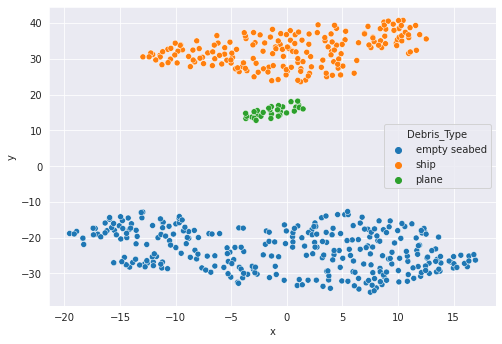

In [33]:
sns.scatterplot(
    x="x", y="y", hue="Debris_Type", data=df, legend=("plane", "seabed", "ship")
)
plt.show()

Save the model

In [34]:
# torch.save(
#     best_model.state_dict(), os.path.join(DIU_AMMO_MODELS_DIR, "unbalanced_model.pth")
# )